In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
from collections import abc

import numpy as np
from matplotlib import pyplot as plt

from harmonic_balance import arclength_continuation as alc
from harmonic_balance import freq, solve

ndarray = np.ndarray

## Define nonlinear force

In [ ]:
def get_slice(dof: int, N: int):
    return np.s_[dof * N : (dof + 1) * N]


def get_nonlinear(
    factor: float,
) -> tuple[
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
]:
    dof = 0
    s_ = lambda N: get_slice(dof, N)

    def f_nl(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * x[s_(N)] ** 3
        return res

    def df_nl_dx(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * 3 * x[s_(N)] ** 2
        return np.diag(res)

    def df_nl_d_xdot(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        shape = x.shape[0]
        return np.zeros((shape, shape), dtype=float)

    return f_nl, df_nl_dx, df_nl_d_xdot

## Define system

In [ ]:
omega = 2
n = 2

m1, m2 = 1, 2
c1, c2, c3 = 1, 0.5, 2
k1, k2, k3 = 1, 0.5, 2

M = np.diag([m1, m2])
C = np.array([[c1 + c2, -c2], [-c2, c2 + c3]])
K = np.array([[k1 + k2, -k2], [-k2, k2 + k3]])

ks = (1, 1)
dofs = (0, 1)
is_cosines = (1, 0)
coefficients = (2, 1)

factor = 10
f_nl, df_nl_dx, df_nl_d_xdot = get_nonlinear(factor)

## Set harmonic balance parameters

In [ ]:
NH = 30
N = 128

b_ext = freq.get_b_ext(NH, n, ks, dofs, is_cosines, coefficients)

## Run harmonic balance

In [ ]:
s = 0.05

tol = 1e-11
max_iter = 100

omega_i0 = 2
A_i0 = freq.get_A(omega_i0, NH, M, C, K)
initial_guess = freq.solve_linear_system(A_i0, b_ext)
z_i0, *_ = solve.solve_nonlinear(
    omega_i0,
    initial_guess,
    A_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    tol,
    max_iter=max_iter,
)

omega_i1 = omega_i0 + s
A_i1 = freq.get_A(omega_i1, NH, M, C, K)
initial_guess = freq.solve_linear_system(A_i1, b_ext)
z_i1, *_ = solve.solve_nonlinear(
    omega_i1,
    initial_guess,
    A_i1,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    tol,
    max_iter=max_iter,
)

## Test predict and correct

In [ ]:
tol = 1e-11
max_iter = 50

y_i0 = np.concat((z_i0, [omega_i0]))
y_i1 = np.concat((z_i1, [omega_i1]))
y_i2_k0 = alc.predict_y(y_i1, y_i0, s)

y_i2, rhs, converged, iters = alc.correct_y(
    y_i2_k0,
    y_i1,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
)

omega_i2, z_i2 = y_i2[-1].real, y_i2[:-1]

In [ ]:
print(f"norm(rhs) / norm(y_i2): {alc.get_rel_error(rhs, y_i2):.5e}")
print(f"iterations: {iters}")
print(f"norm(y_i2 - y_i1): {np.linalg.norm(y_i2 - y_i1):.15f}")
print(f"omega_i2: {omega_i2:.5f}")

norm(rhs) / norm(y_i2): 4.44828e-12
iterations: 38
norm(y_i2 - y_i1): 0.050000000000733
omega_i2: 2.09059


## Compute NLFR curve

In [ ]:
omega_i0 = 0.1

num_points = 200
s = 0.05
tol = 1e-6
max_iter = 100

ys, rel_errors, convergeds, iters = alc.compute_nlfr_curve(
    num_points,
    omega_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
)

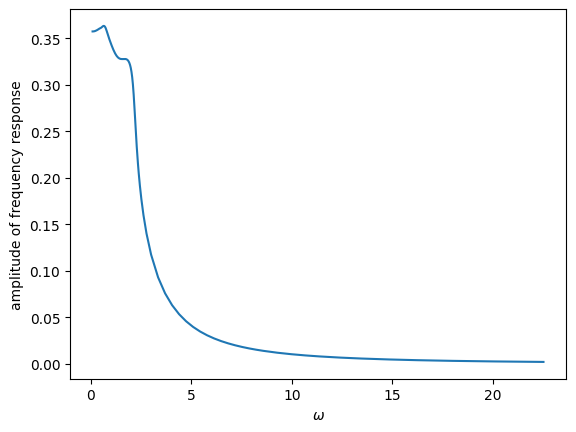

In [ ]:
amplitudes = np.linalg.norm(ys[:, :-1], axis=1)
omegas = ys[:, -1].real

fig, ax = plt.subplots(1, 1)

ax.plot(omegas, amplitudes)
ax.set_xlabel("$\omega$")
ax.set_ylabel("amplitude of frequency response")

plt.show()

In [ ]:
iters

array([17, 17,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10,  9,  9,
        8,  8,  9, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 11, 11,
       11, 11, 10, 11, 10, 11, 11, 10, 11, 10, 11, 10, 11, 10, 10, 11, 10,
       11, 10, 10, 11, 10, 10, 11, 10, 10, 11, 10, 10, 10, 11, 10, 10, 10,
       11, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  7,
        7,  7,  6,  6,  5,  5,  4,  4,  4,  3,  3,  3,  3,  3,  2,  2,  2,
        2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])